#**Start the Code!**💡

#**Importing librares**

**Import all the important libraries regard the data and models that will be used**

In [ ]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, classification_report, auc, precision_recall_curve
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Dense, LSTM, SimpleRNN, BatchNormalization, Dropout, Flatten, Bidirectional
)
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd

#**Load the data**

**Download the ASVspoof 2019 dataset from Kaggle and unzip the file**

In [ ]:
# Download the dataset from Kaggle
!kaggle datasets download -d awsaf49/asvpoof-2019-dataset

# Unzip the downloaded files
!unzip asvpoof-2019-dataset.zip

#**Data Preprocessing**

**Define the paths and paramentes for the ASVspoof dataset**

where the path contains the audio files and the label path contains a text file with the corresponding labels



## **CONFIGS**

In [ ]:
#Define the configurartions
FOLDS = 10
SEED = 101
DEBUG = True
BASE_PATH = "/content/LA/LA"

In [ ]:
# Define paths
DATASET_PATH = "/content/LA/LA/ASVspoof2019_LA_train/flac"
LABEL_FILE_PATH = "/content/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt"
NUM_CLASSES = 2  # Number of classes (bonafide and spoof)


# Audio parameters
SAMPLE_RATE = 16000  # Sample rate of the audio files
DURATION = 5  # Duration of audio clips in seconds
N_MELS = 128  # Number of Mel frequency bins
MAX_TIME_STEPS = 109
AUDIO_LEN = int(SAMPLE_RATE * DURATION)

In [ ]:
# Spectrogram params
N_MELS = 128 # freq axis
N_FFT = 2048
SPEC_WIDTH = 256 # time axis
HOP_LEN = AUDIO_LEN//(SPEC_WIDTH - 1) # non-overlap region
FMAX = SAMPLE_RATE//2 # max frequency
SPEC_SHAPE = [SPEC_WIDTH, N_MELS] # output spectrogram shape

**Labeling the training data with 1 for real bonafide (human) audios and 0 for spoofed speech**

In [ ]:
# Label the data
labels = {}

with open(LABEL_FILE_PATH, 'r') as label_file:
    lines = label_file.readlines()

for line in lines:
    parts = line.strip().split()
    file_name = parts[1]
    label = 1 if parts[-1] == "bonafide" else 0
    labels[file_name] = label

**Print the Labels Type and Items**

In [ ]:
# Print the labels type
type(labels)

dict

In [ ]:
# Print the labels items
print(labels.items())

dict_items([('LA_T_1138215', 1), ('LA_T_1271820', 1), ('LA_T_1272637', 1), ('LA_T_1276960', 1), ('LA_T_1341447', 1), ('LA_T_1363611', 1), ('LA_T_1596451', 1), ('LA_T_1608170', 1), ('LA_T_1684951', 1), ('LA_T_1699801', 1), ('LA_T_1703395', 1), ('LA_T_1736342', 1), ('LA_T_1779188', 1), ('LA_T_1786825', 1), ('LA_T_1787246', 1), ('LA_T_1905558', 1), ('LA_T_2205687', 1), ('LA_T_2220901', 1), ('LA_T_2361751', 1), ('LA_T_2373806', 1), ('LA_T_2417641', 1), ('LA_T_2520083', 1), ('LA_T_2562689', 1), ('LA_T_2564579', 1), ('LA_T_2732709', 1), ('LA_T_2759900', 1), ('LA_T_2838981', 1), ('LA_T_2873890', 1), ('LA_T_2938316', 1), ('LA_T_3131990', 1), ('LA_T_3141223', 1), ('LA_T_3167734', 1), ('LA_T_3187715', 1), ('LA_T_3215578', 1), ('LA_T_3247389', 1), ('LA_T_3346004', 1), ('LA_T_3441957', 1), ('LA_T_3561136', 1), ('LA_T_3576775', 1), ('LA_T_3580508', 1), ('LA_T_3635733', 1), ('LA_T_3636245', 1), ('LA_T_3810183', 1), ('LA_T_3849267', 1), ('LA_T_3995089', 1), ('LA_T_3999087', 1), ('LA_T_3999267', 1), (

**Counting the data distribution**

<ipython-input-9-8cf34b83b3e6>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df['Label'].value_counts().index, y=df['Label'].value_counts().values, palette='bright')


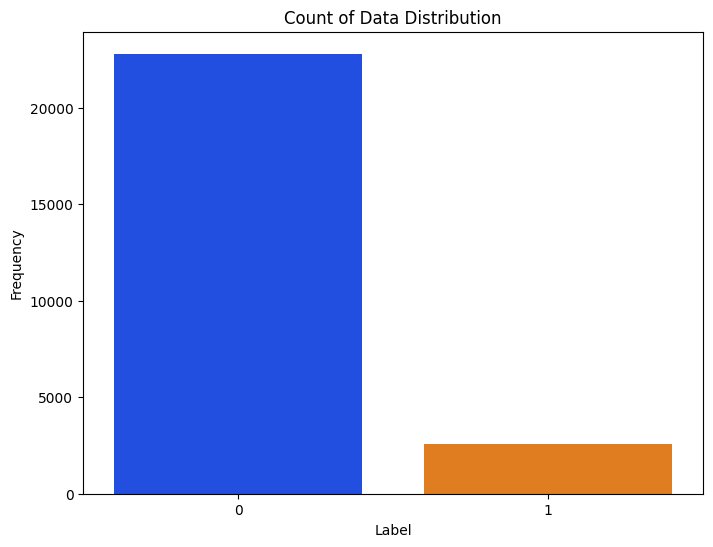

In [ ]:
# Plot the distrubtion of the classes using Dataframe
df = pd.DataFrame(list(labels.values()), columns=['Label'])
plt.figure(figsize=(8, 6))
sns.barplot(x=df['Label'].value_counts().index, y=df['Label'].value_counts().values, palette='bright')
plt.title('Count of Data Distribution')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

**data are highly imbalance, due to low precistion in labelling the data, null values have not been checked. setting all "else" values to 0 is a naive approach. which could lead to a decrease in accuracy and other problems**

In [ ]:
# Balancing the classes of the dataset
trn_data_df = pd.read_csv(f"/content/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt",
                       sep=" ", header=None)
trn_data_df.columns =['speaker_id','filename','system_id','null','class_name']
trn_data_df.drop(columns=['null'],inplace=True) # drop null values
trn_data_df['filepath'] = f'{BASE_PATH}/ASVspoof2019_LA_train/flac/'+trn_data_df.filename+'.flac'


trn_data_df['target'] = (trn_data_df.class_name=='spoof').astype('int32') # set labels 1 for fake and 0 for real
if DEBUG:
    trn_data_df = trn_data_df.groupby(['target']).sample(2500).reset_index(drop=True)
print(f'Train Samples: {len(trn_data_df)}')
trn_data_df.head(2)

Train Samples: 5000


,speaker_id,filename,system_id,class_name,filepath,target
0,LA_0081,LA_T_4513430,-,bonafide,/content/LA/LA/ASVspoof2019_LA_train/flac/LA_T...,0
1,LA_0079,LA_T_1703395,-,bonafide,/content/LA/LA/ASVspoof2019_LA_train/flac/LA_T...,0


**Print the results after balancing the data**

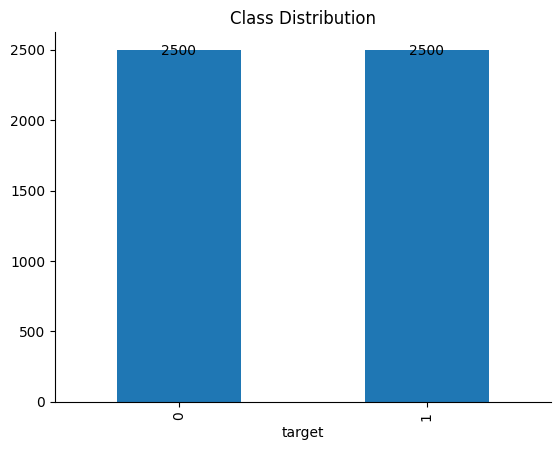

In [ ]:
# Plot the distibution after balancing the classes
from matplotlib import pyplot as plt
import seaborn as sns
class_counts = trn_data_df.groupby('target').size()
ax = class_counts.plot(kind='bar', title='Class Distribution')

plt.gca().spines[['top', 'right',]].set_visible(False)

for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()

#**Data Visualization**

**Define the Functions for data visulaization**

In [ ]:
# Create a function that define the audio
def load_audio(path, sr=16000):
    """load audio from .wav file
    Args:
        path: file path of .wav file
        sr: sample rate
    Returns:
        audio, sr
    """
    audio, sr = librosa.load(path, sr=sr)
    return audio, sr

# Create the funtion that polts the audio
def plot_audio(audio, sr=16000):
    fig = librosa.display.waveshow(audio,
                             x_axis='time',
                             sr=sr)
    return fig

# Create a function to listen to the audio
def listen_audio(audio, sr=16000):
    display(ipd.Audio(audio, rate=sr))

# Create a function the return the Mel Spectrofram
def get_spec(audio):
    spec = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS, hop_length=HOP_LEN, n_fft=N_FFT, fmax=FMAX)
    spec = librosa.power_to_db(spec)
    return spec

# Create a function the plot the Mel Spectrofram
def plot_spec(spec, sr=16000):
    fig = librosa.display.specshow(spec,
                             x_axis='time',
                             y_axis='hz',
                             hop_length=HOP_LEN,
                             sr=SAMPLE_RATE,
                             fmax=FMAX,)
    return fig

### ***REAL AUDIO SAMPLE***

> Filename: LA_T_4857746 | Label: bonafide
# Listen


# Plot



<ipython-input-12-8504ad431797>:13: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  fig = librosa.display.waveshow(audio,


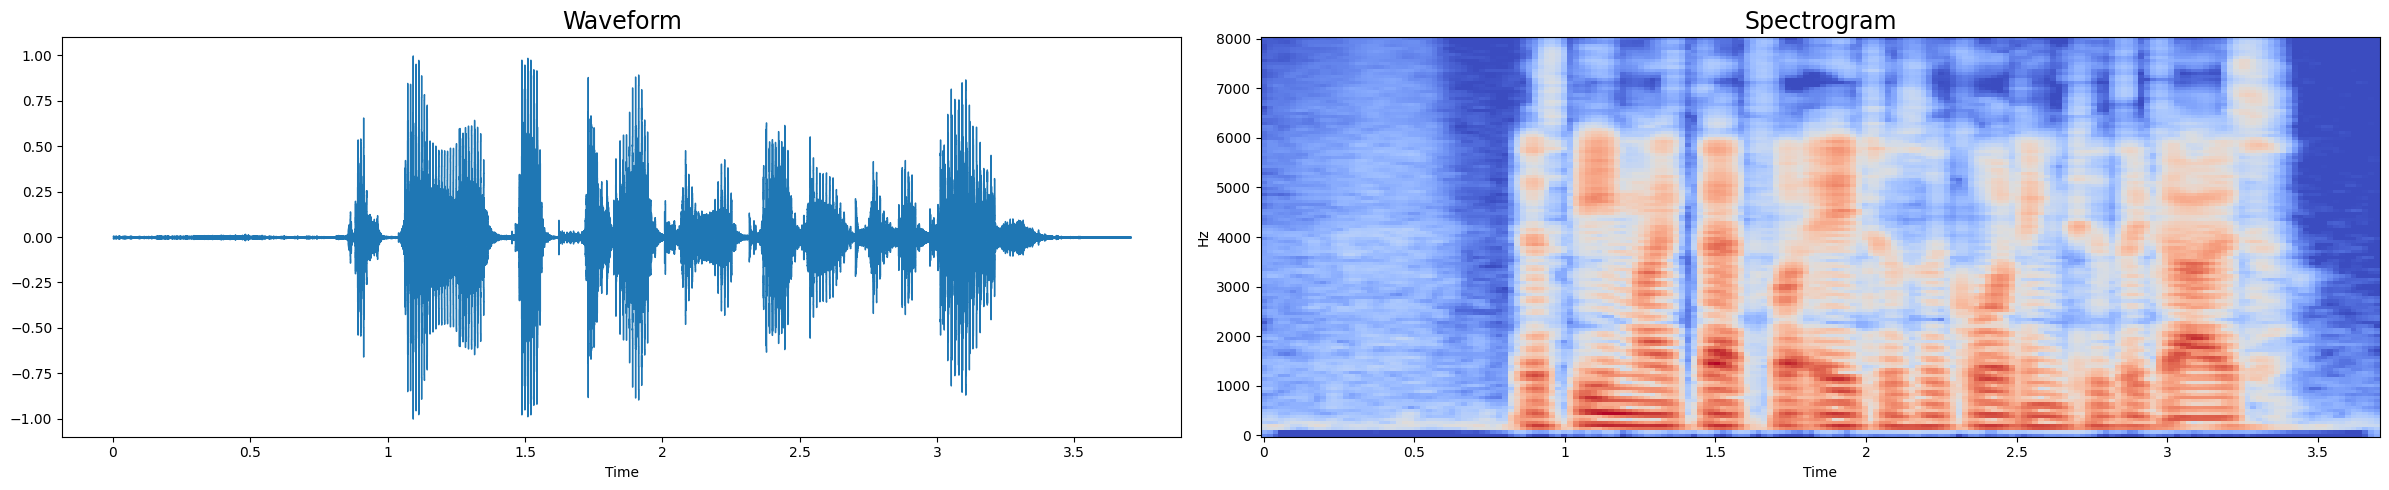

In [ ]:
# Printing the real audio
row = trn_data_df[trn_data_df.target==0].iloc[10]
print(f'> Filename: {row.filename} | Label: {row.class_name}')
audio, sr= load_audio(row.filepath, sr=None)
audio = audio[:AUDIO_LEN]
spec = get_spec(audio)

print('# Listen')
listen_audio(audio, sr=16000)

print("# Plot\n")
plt.figure(figsize=(12*2,5))

plt.subplot(121)
plot_audio(audio)
plt.title("Waveform",fontsize=17)

plt.subplot(122)
plot_spec(spec);
plt.title("Spectrogram",fontsize=17)

plt.tight_layout()
plt.show()

### ***FAKE AUDIO SAMPLE***

Filename: LA_T_1192982 | Label: spoof
# Listen


# Plot



<ipython-input-12-8504ad431797>:13: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  fig = librosa.display.waveshow(audio,


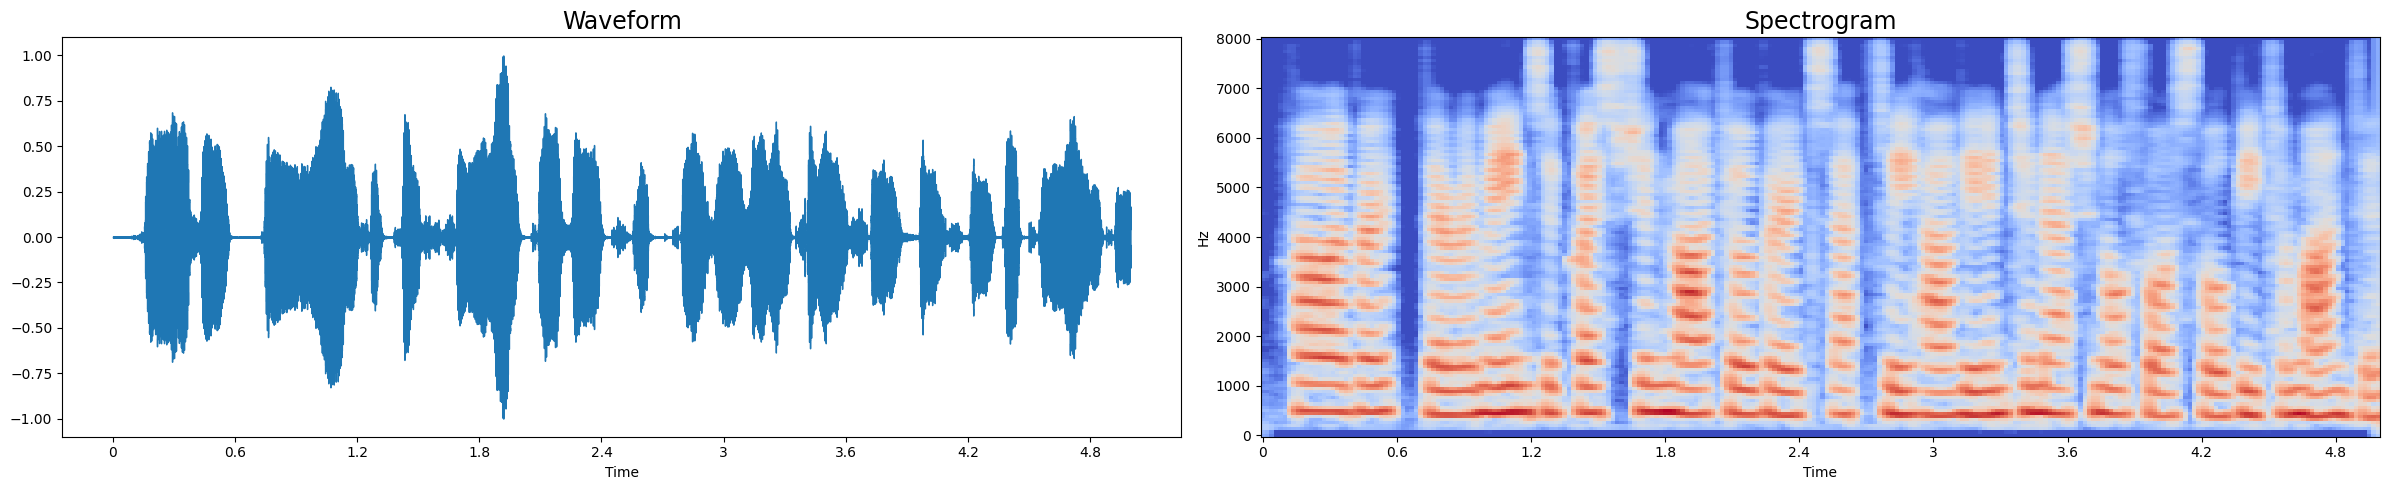

In [ ]:
# Printing the fake audio
row = trn_data_df[trn_data_df.target==1].iloc[10]
print(f'Filename: {row.filename} | Label: {row.class_name}')
audio, sr= load_audio(row.filepath, sr=None)
audio = audio[:AUDIO_LEN]
spec = get_spec(audio)

print('# Listen')
listen_audio(audio, sr=16000)

print("# Plot\n")
plt.figure(figsize=(12*2,5))

plt.subplot(121)
plot_audio(audio)
plt.title("Waveform",fontsize=17)

plt.subplot(122)
plot_spec(spec);
plt.title("Spectrogram",fontsize=17)

plt.tight_layout()
plt.show()

**Extract the Mel-spectrogram features**

Mel-spectrogram features represent an audio signal's frequency content on a human-perceptive Mel scale, and are used to capture subtle spectral patterns indicative of synthetic or manipulated audio.

X will contain a list of Mel-spectrogram features and Y a list of labels using the librosa library

In [ ]:
# Print the data head
print(trn_data_df.head())

  speaker_id      filename system_id class_name  \
0    LA_0081  LA_T_4513430         -   bonafide   
1    LA_0079  LA_T_1703395         -   bonafide   
2    LA_0087  LA_T_2034214         -   bonafide   
3    LA_0088  LA_T_9793995         -   bonafide   
4    LA_0089  LA_T_9363134         -   bonafide   

                                            filepath  target  
0  /content/LA/LA/ASVspoof2019_LA_train/flac/LA_T...       0  
1  /content/LA/LA/ASVspoof2019_LA_train/flac/LA_T...       0  
2  /content/LA/LA/ASVspoof2019_LA_train/flac/LA_T...       0  
3  /content/LA/LA/ASVspoof2019_LA_train/flac/LA_T...       0  
4  /content/LA/LA/ASVspoof2019_LA_train/flac/LA_T...       0  


In [ ]:
# Extract Mel-Spectrogram feature
X = []
y = []

max_time_steps = 109  # Define the maximum time steps

for row in trn_data_df.itertuples(index=False):
    file_name = row.filename
    label = row.target
    file_path = os.path.join(DATASET_PATH, file_name + ".flac")

    # Load audio file using librosa
    audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)

    # Extract Mel spectrogram using librosa
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Ensure all spectrograms have the same width (time steps)
    if mel_spectrogram.shape[1] < MAX_TIME_STEPS:
        mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, MAX_TIME_STEPS - mel_spectrogram.shape[1])), mode='constant')
    else:
        mel_spectrogram = mel_spectrogram[:, :MAX_TIME_STEPS]

    X.append(mel_spectrogram)
    y.append(label)

**Defining X for audio samples and Y for the labels and print the results**

In [ ]:
# Defining X and Y
X = np.array(X)
y = to_categorical(y, NUM_CLASSES)

X,y

#**Start with Building and Evaluating the Models!**

##**Data Training**

**For the model architectures we choose Recurrent neural network (RNN) and long short-term memory (LSTM) to be our architectures and ReLU and softmax to be our activation function and adam for the optimizing**

---

**Split the dataset into 80 percent for training and 20 percent for testing**

In [ ]:
# Train-test split

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

**Creating an evaluation function to evaluate each model**

The evaluation will be mainly concern with accuracy, precision, recall, F1-score, the equal error rate (EER), area under the curve (AUC), and receiver operating characteristics (ROC)

In [ ]:
# Evaluate models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    accuracy = accuracy_score(y_true, y_pred_classes)
    precision = precision_score(y_true, y_pred_classes, average="weighted")
    recall = recall_score(y_true, y_pred_classes, average="weighted")
    f1 = f1_score(y_true, y_pred_classes, average="weighted")
    auc = roc_auc_score(y_test, y_pred, multi_class="ovr")

    fpr, tpr, _ = roc_curve(y_test[:, 1], y_pred[:, 1])
    eer = fpr[np.nanargmin(np.absolute((1 - tpr) - fpr))]

    return accuracy, precision, recall, f1, auc, eer, fpr, tpr

In [ ]:
# Define some learning rate parameters
from tensorflow.keras.callbacks import LearningRateScheduler

# Define scheduler function
def scheduler(epoch, lr):
    return lr * 0.9 if epoch > 5 else lr

# Add LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(scheduler)

callbacks=[lr_scheduler]

##**1. RNN Model**




**The following is a functions to desfine RNN model**



In [ ]:
# Define RNN Model
def build_rnn_model(input_shape):
    model = Sequential([
        SimpleRNN(64, input_shape=input_shape, return_sequences=True),
        BatchNormalization(),
        Dropout(0.5),
        Flatten(),
        Dense(64, activation="relu"),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation="softmax")
    ])
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

**Training the model**

In [ ]:
# Start training the model
print("Training RNN model...")
rnn_model = build_rnn_model(X_train.shape[1:])
rnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, callbacks=[lr_scheduler])

##**RNN Model Evaluation**

In [ ]:
# Define the model's metrics
rnn_metrics = evaluate_model(rnn_model, X_test, y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


In [ ]:
# Extract the evaluation metrics
RNN_accuracy, RNN_precision, RNN_recall, RNN_f1, RNN_auc, RNN_eer, RNN_fpr, RNN_tpr = rnn_metrics

# Print the evaluation results
print(f"RNN Model Evaluation Metrics:")
print(f"Accuracy: {RNN_accuracy:.4f}")
print(f"Precision: {RNN_precision:.4f}")
print(f"Recall: {RNN_recall:.4f}")
print(f"F1-Score: {RNN_f1:.4f}")
print(f"AUC: {RNN_auc:.4f}")
print(f"EER: {RNN_eer:.4f}")

RNN Model Evaluation Metrics:
Accuracy: 0.8440
Precision: 0.8596
Recall: 0.8440
F1-Score: 0.8423
AUC: 0.9297
EER: 0.1520


**Accuracy:** 84.4% accuracy indicate an excellent classiclassification of the test samples.

**Precision:** among all the samples classified as real audio, about 85.96% are actually positive.

**Recall:** The model identifies 84.4% of the actual positive samples

**F1-Score:** 84.23% is good balance between precision and recall.

**AUC:** 92.97% is an excellent ability to distinguish between classes

**EER:** 15.2% is an accepted representiation of the point where false positive and false negative rates are equal.



Overall the model shows good performance, however, there might be room for improvement

----

**Plot the precision_recall curve**

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


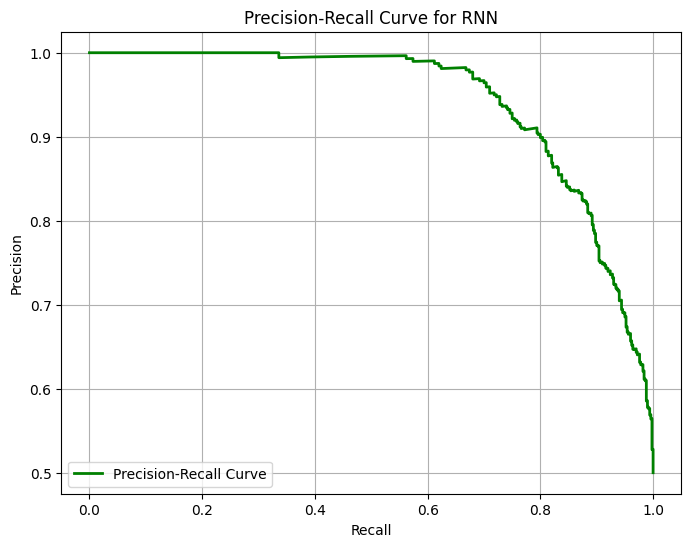

In [ ]:
# Define the function for plotting the precision and recall curve
def plot_precision_recall_curve(y_test, y_pred_probs, model_name="RNN"):
    precision, recall, _ = precision_recall_curve(y_test[:, 1], y_pred_probs[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='green', lw=2, label=f'Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {model_name}')
    plt.legend(loc='lower left')
    plt.grid()
    plt.show()

# Plot Precision-Recall Curve
plot_precision_recall_curve(y_test, rnn_model.predict(X_test), model_name="RNN")


The Precision-Recall curve indicates that the RNN model achieves a good balance between precision and recall at lower thresholds, but precision declines as recall increases, suggesting the model's confidence decreases when aiming for higher recall.


This means that as the model tries to correctly identify more positive samples (achieving higher recall), it makes more incorrect positive predictions, which reduces its precision.

---



**Plot the ROC curve with AUC and EER**

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


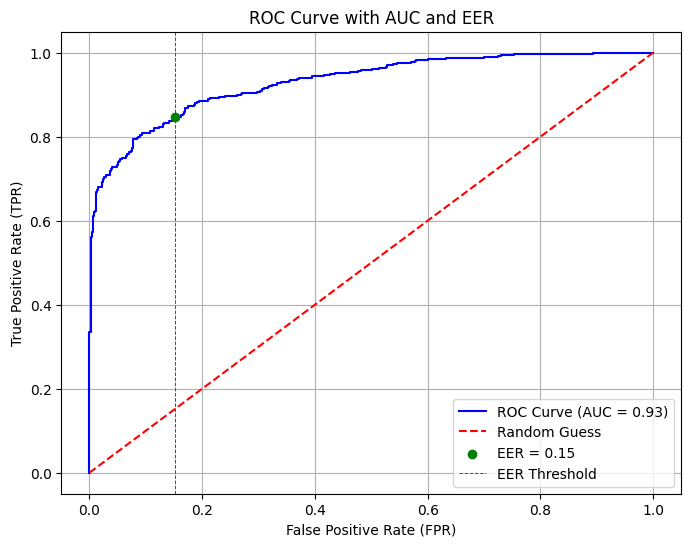

AUC: 0.93
EER: 0.15 at Threshold = 0.47


In [ ]:
# Plot the ROC curve
rnn_y_pred = rnn_model.predict(X_test)
a,b,thresholds = roc_curve(y_test[:, 1], y_pred[:, 1])
roc_auc = auc(RNN_fpr, RNN_tpr)

# Calculate EER
fnr = 1 - RNN_tpr
eer_threshold_index = np.nanargmin(np.abs(fnr - RNN_fpr))
eer = RNN_fpr[eer_threshold_index]  # EER is where FPR = FNR
eer_threshold = thresholds[eer_threshold_index]

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(RNN_fpr, RNN_tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')
plt.scatter(RNN_fpr[eer_threshold_index], RNN_tpr[eer_threshold_index], color='green', label=f'EER = {eer:.2f}', zorder=5)
plt.axvline(RNN_fpr[eer_threshold_index], color='green', linestyle='--', linewidth=0.7, label='EER Threshold')

# Add labels and legend
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve with AUC and EER')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Print AUC and EER
print(f"AUC: {roc_auc:.2f}")
print(f"EER: {eer:.2f} at Threshold = {eer_threshold:.2f}")


The ROC curve demonstrates strong discriminatory power with an ROC curve close to the top-left corner and an AUC of 0.93, indicating it effectively distinguishes between real and fake audio.

---

**Plot the confusion matrix**

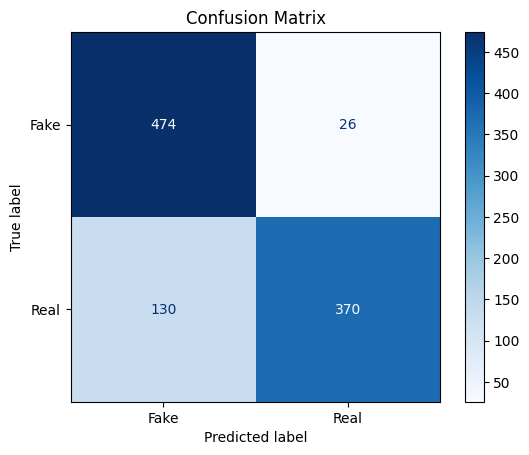

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convert to predicted classes
y_pred_classes = np.argmax(rnn_y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Fake', 'Real'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

This plot shows the confusion Matrix, it appears that the model excel in classifying fake audios and avoiding false positive. However there might be room for improving the false negative.  

---

##**2. LSTM Model**




**The following is a functions to desfine LSTM model**

In [ ]:
#  Define LSTM Model
def build_lstm_model(input_shape):
    model = Sequential([
        Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.3),
        Bidirectional(LSTM(64, return_sequences=False)),
        Dense(64, activation="relu"),
        Dropout(0.3),
        Dense(NUM_CLASSES, activation="softmax")
    ])
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

**Training the model**

In [ ]:
# Train the LSTM Model
print("Training LSTM model...")
lstm_model = build_lstm_model(X_train.shape[1:])
lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, callbacks=[lr_scheduler])

Training LSTM model...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 101s 752ms/step - accuracy: 0.6159 - loss: 0.6393 - val_accuracy: 0.6180 - val_loss: 0.6659 - learning_rate: 0.0010
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 144s 768ms/step - accuracy: 0.7510 - loss: 0.4915 - val_accuracy: 0.7060 - val_loss: 0.5426 - learning_rate: 0.0010
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 143s 777ms/step - accuracy: 0.7725 - loss: 0.4647 - val_accuracy: 0.5410 - val_loss: 0.8150 - learning_rate: 0.0010
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 95s 763ms/step - accuracy: 0.7843 - loss: 0.4559 - val_accuracy: 0.5090 - val_loss: 1.3731 - learning_rate: 0.0010
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 141s 754ms/step - accuracy: 0.8250 - loss: 0.3956 - val_accuracy: 0.5600 - val_loss: 0.8392 - learning_rate: 0.0010
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 145s 777ms/step - accuracy: 0.8219 - loss: 0.3966 - val_accuracy: 0.5000 - val_loss: 2.6235 - learning_rate: 0.0010
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 95s 760ms/step - accuracy

##**LSTM Model Evaluation**

In [ ]:
# Define the model's metrics
lstm_metrics = evaluate_model(lstm_model, X_test, y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 211ms/step


In [ ]:
# Extract the evaluation metrics
LSTM_accuracy, LSTM_precision, LSTM_recall, LSTM_f1, LSTM_auc, LSTM_eer, LSTM_fpr, LSTM_tpr = lstm_metrics

# Print the evaluation results
print(f"RNN Model Evaluation Metrics:")
print(f"Accuracy: {LSTM_accuracy:.4f}")
print(f"Precision: {LSTM_precision:.4f}")
print(f"Recall: {LSTM_recall:.4f}")
print(f"F1-Score: {LSTM_f1:.4f}")
print(f"AUC: {LSTM_auc:.4f}")
print(f"EER: {LSTM_eer:.4f}")

RNN Model Evaluation Metrics:
Accuracy: 0.8420
Precision: 0.8438
Recall: 0.8420
F1-Score: 0.8418
AUC: 0.9198
EER: 0.1580


**Accuracy:** 84.2% accuracy indicate an excellent classiclassification of the test samples.

**Precision:** among all the samples classified as real audio, about 84.38% are actually positive. this could be improved to overcome the false positive.

**Recall:** The model identifies 84.2% of the actual positive samples

**F1-Score:** 84.18% indicate a good balance between precision and recall.

**AUC:** 91.98% means that the model is highly able to distinguish between the classes very well

**EER:** 15.8% is quite good representiation of the point where false positive and false negative rates are equal. Lowering it to 10% or lower would be better.




The model shows good overall performance.

**Plot the precision_recall curve**

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 223ms/step


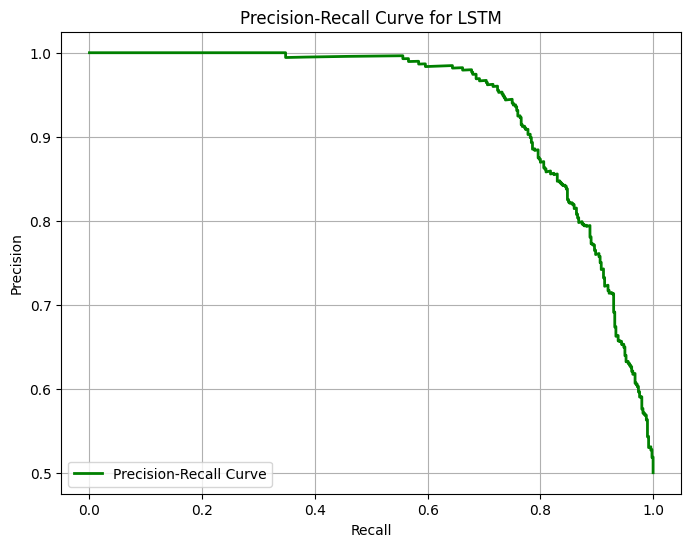

In [ ]:
# Plot Precision-Recall Curve
plot_precision_recall_curve(y_test, lstm_model.predict(X_test), model_name="LSTM")

The precision-recall curve demonstrates a decrease in precision as recall increases, indicating that the model struggles to maintain high precision while attempting to capture all positive instances

------------

**Plot the ROC curve with AUC and EER**

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 206ms/step


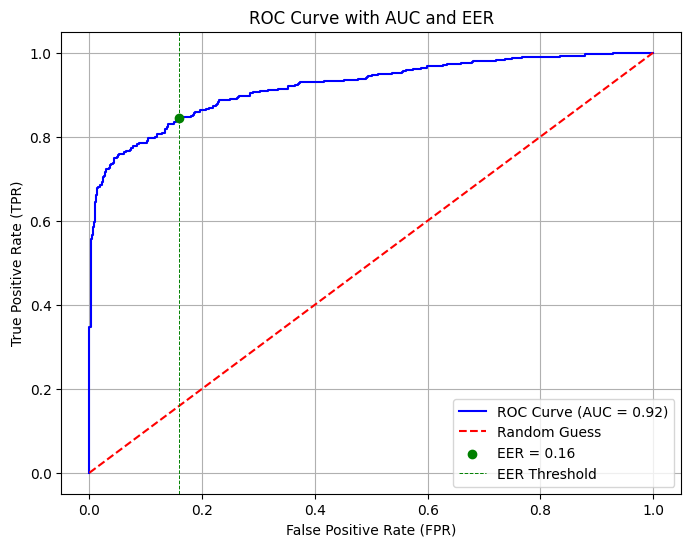

AUC: 0.92
EER: 0.16 at Threshold = 0.42


In [ ]:
# Plot the ROC curve
lstm_y_pred = lstm_model.predict(X_test)
a,b,thresholds = roc_curve(y_test[:, 1], y_pred[:, 1])
roc_auc = auc(LSTM_fpr, LSTM_tpr)

# Calculate EER
fnr = 1 - LSTM_tpr
eer_threshold_index = np.nanargmin(np.abs(fnr - LSTM_fpr))
eer = LSTM_fpr[eer_threshold_index]  # EER is where FPR = FNR
eer_threshold = thresholds[eer_threshold_index]

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(LSTM_fpr, LSTM_tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')
plt.scatter(LSTM_fpr[eer_threshold_index], LSTM_tpr[eer_threshold_index], color='green', label=f'EER = {eer:.2f}', zorder=5)
plt.axvline(LSTM_fpr[eer_threshold_index], color='green', linestyle='--', linewidth=0.7, label='EER Threshold')

# Add labels and legend
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve with AUC and EER')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Print AUC and EER
print(f"AUC: {roc_auc:.2f}")
print(f"EER: {eer:.2f} at Threshold = {eer_threshold:.2f}")

The curve shows moderate discrimination, with a steady rise in TPR against FPR but not close to the ideal top-left corner. This plot shows the AUC and EER in the ROC curve

---

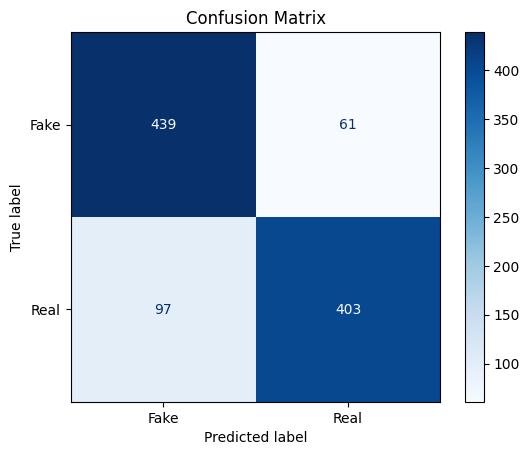

In [ ]:
# Convert to predicted classes
y_pred_classes = np.argmax(lstm_y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Fake', 'Real'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


This plot shows the confusion Matrix, it appears that the model excel in classifying fake and real audios and avoiding false positive and false negative.


##**Compare the Performance of the Models!**

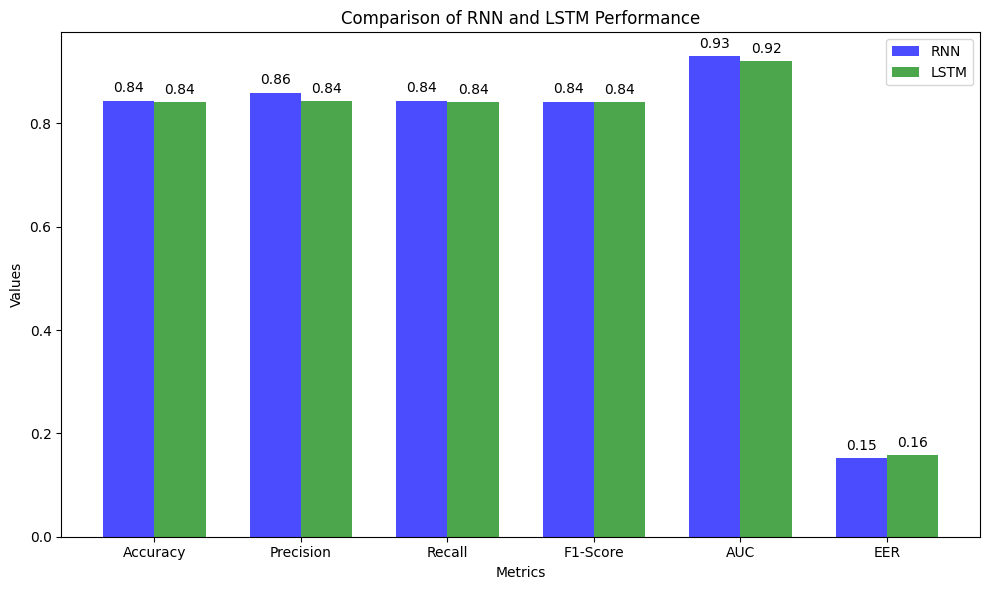

In [ ]:
# Define the metrics for RNN and LSTM
metrics = ["Accuracy", "Precision", "Recall", "F1-Score", "AUC", "EER"]
rnn_values = [RNN_accuracy, RNN_precision, RNN_recall, RNN_f1, RNN_auc, RNN_eer]
lstm_values = [LSTM_accuracy, LSTM_precision, LSTM_recall, LSTM_f1, LSTM_auc, LSTM_eer]

# Create a bar plot to compare RNN and LSTM metrics
x = np.arange(len(metrics))  # Create an array for the metric indices
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
bars_rnn = ax.bar(x - width/2, rnn_values, width, label="RNN", color="blue", alpha=0.7)
bars_lstm = ax.bar(x + width/2, lstm_values, width, label="LSTM", color="green", alpha=0.7)

# Add labels, title, and legend
ax.set_xlabel("Metrics")
ax.set_ylabel("Values")
ax.set_title("Comparison of RNN and LSTM Performance")
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Annotate bars with values
for bar in bars_rnn:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f"{bar.get_height():.2f}", ha='center', va='bottom')
for bar in bars_lstm:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f"{bar.get_height():.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


As seen in the above comparison, the RNN model outperforms the LSTM  which suggest a better overall classification performance. However, both models exhibit similar results.

----

#**Conclusion**

in conclusion. Detecting deepfakes has become essential for ensuring voice authenticity and system security. By utilizing Mel-Spectrogram Extraction and deep learning models—RNN for temporal sequences and LSTM for long-term dependencies—we achieved reliable detection. The RNN slightly outperformed LSTM. Further consideration would include more fine-tuning hyperparameters, capturing more complex patterns, training the models with more data, and experimenting with advanced architecture.